In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from basic_tools import *

debug=False

# Load variables

## Load codebook

In [4]:
codebook_AS=pd.read_csv(codebook_AS_path)#,header=1)
codebook_CT=pd.read_csv(codebook_CT_path)#,header=1)
codebook_NC=pd.read_csv(codebook_NC_path)

codebook_column_dict={"테이블명(영문)":"table_code","변수명": "phenotype_code","변수설명":"description", "변수값(코드) 설명": "value_description","변수유형":"type","설문지":"questionnaire"}
codebook_AS=codebook_AS.rename(columns=codebook_column_dict)
codebook_CT=codebook_CT.rename(columns=codebook_column_dict)
codebook_NC=codebook_NC.rename(columns=codebook_column_dict)

codebook_AS['type']=codebook_AS['type'].replace('범주형','categorical').replace('연속형','continuous').replace('서술형','descriptive').replace('날짜','date')
codebook_CT['type']=codebook_CT['type'].replace('범주형','categorical').replace('연속형','continuous').replace('서술형','descriptive').replace('날짜','date')
codebook_NC['type']=codebook_NC['type'].replace('범주형','categorical').replace('연속형','continuous').replace('서술형','descriptive').replace('날짜','date')

codebook_AS['phenotype_code']=codebook_AS['phenotype_code'].str.upper()

codebook_total=pd.concat([codebook_AS,codebook_CT,codebook_NC])

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


In [5]:
def codebook_selector(cohort):
    if cohort=='AS':
        return codebook_AS
    elif cohort=='CT':
        return codebook_CT
    elif cohort=='NC':
        return codebook_NC
    else:
        raise

In [6]:
codebook_custommerge=pd.read_csv(codebook_custommerge_path)
codebook_custommerge
codebook_custommerge=codebook_custommerge.rename(columns=codebook_column_dict)
codebook_custommerge['phenotype_code']=codebook_custommerge['phenotype_code'].str.upper()

## Load phenotype information of individuals

In [7]:
phenotype_raw_AS=pd.read_csv(phenotype_raw_AS_path,sep='\t',index_col='ID')
phenotype_raw_AS['AS1_contain']=1
phenotype_raw_CT=pd.read_csv(phenotype_raw_CT_path,sep='\t',index_col='ID')
phenotype_raw_CT['CT1_contain']=1
phenotype_raw_NC=pd.read_csv(phenotype_raw_NC_path,sep='\t',index_col='ID')
phenotype_raw_NC.columns=phenotype_raw_NC.columns.str.replace('NCB','NC1')
phenotype_raw_NC['NC1_contain']=1

phenotype_raw_AS.shape,phenotype_raw_CT.shape,phenotype_raw_NC.shape

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (9,11,158,552,1301) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (391,516) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (87,97,101,105,208,270,373,382,388) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


((7612, 1316), (99234, 578), (19004, 431))

In [8]:
phenotype_raw=pd.concat([phenotype_raw_AS,phenotype_raw_CT,phenotype_raw_NC])
phenotype_raw=phenotype_raw.sort_values('ID')
phenotype_raw.shape

/home/ch6845/tools/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


(125850, 2325)

# (deprecated) Step1. duplicated phenotype code

## Group variable of common phenotype code

In [7]:
phenotype_raw_columns=phenotype_raw.columns.to_series()
phenotype_raw_columns[phenotype_raw_columns.index]=phenotype_raw_columns.index.str.slice(start=4)
phenotype_raw_columns=phenotype_raw_columns[phenotype_raw_columns.duplicated(keep=False)]
phenotype_groups=phenotype_raw_columns.groupby(phenotype_raw_columns).groups

# Codes for conversion

# Automatically make conversion manual

In [19]:
conversion_manual=pd.DataFrame(columns=['phenotype_code','commands','custom_id'])
conversion_manual.set_index('phenotype_code',inplace=True)

In [20]:
codebook_total_temp=codebook_total.copy()
codebook_total_temp=codebook_total_temp.applymap(lambda x: replace_characters(x,{'\n':'',' ':'','■':'',',':''}))

In [21]:
for idx,row in codebook_total_temp.iterrows():
    try:
        phenotype_raw_series=phenotype_raw[row['phenotype_code']]
    except KeyError:
        continue
    
    #ignore environmental 
    if '음주' in row['description'] or '빈도' in row['description']:
        continue
    
    #set new phenotype name
    phenotype_name=row['phenotype_code'][4:]
    try:
        phenotype_name_temp=codebook_merged.set_index('phenotype_code')['trait_name'][row['phenotype_code']]
        #print(phenotype_name_temp,'here')
        #print(phenotype_name_temp,type(phenotype_name_temp),np.isnan(phenotype_name_temp))
        if type(phenotype_name_temp)==str:
            phenotype_name=phenotype_name_temp
    except:
        pass
    
    phenotype_name=phenotype_name.replace(' ','_')
    
    if row['type']=='categorical':
        #print(row['value_description'])
        if row['value_description']=='1=아니오2=예':
            conversion_manual.loc[row['phenotype_code']]='{}@x==1@1|{}@x==2@2'.format(phenotype_name,phenotype_name)
        elif row['value_description']=='0=normal1=abnormal':
            conversion_manual.loc[row['phenotype_code']]='{}@x==0@1|{}@x==1@2'.format(phenotype_name,phenotype_name)
        else:
            #print(row['description'],row['value_description'])
            pass
        
    elif row['type']=='continuous':
        conversion_manual.loc[row['phenotype_code']]='{}@(x!=66666)&(x!=77777)&(x!=99999)@x'.format(phenotype_name)

In [22]:
conversion_manual['custom_id']=codebook_merged.set_index('phenotype_code')['일련번호merged'].loc[conversion_manual.index.values]
#conversion_manual.sort_values('custom_id').to_csv(conversion_manual_path,sep='\t')

# Note
Case filtering base. do not include

if merge pheno only exist in a cohort, include them.

exclude medication

include treatment  (more explicit??)

hierachy qudstion do not test under if upper is +

# Run conversion manual

## Run specific (for debugging)

In [29]:
(phenotype_raw['AS1_TRTAS']==2).sum(),(phenotype_raw['AS1_PDAS']==2).sum()

In [9]:
phenotype_raw.index[(phenotype_raw['CT1_ASTHCU']>=1) & (phenotype_raw['CT1_ASTHCU']<=4)].difference(phenotype_raw.index[phenotype_raw['CT1_ASTH']==2])

Index([], dtype='object', name='ID')

In [10]:
a=phenotype_raw.index[phenotype_raw['AS1_TRTAS']==2].difference(phenotype_raw.index[phenotype_raw['AS1_PDAS']==1])

len(a)
#phenotype_raw['AS1_PDAS']==1
#AS1_PdAs

36

In [20]:
phenotype_raw['NC1_CA1'].unique(),phenotype_raw['NC1_CA_NA2'].unique()
#NC1_CA_NA1

(array([6.6666e+04,        nan, 1.0000e+00, 2.0000e+00, 9.9999e+04]),
 array(['77777', '66666', '99999', '전립선암', '폐암', '피부암', '대장암', '자궁암',
        77777, 66666, 99999, nan], dtype=object))

In [ ]:
phenotype_raw['AS1_HIP1'].unique()

In [ ]:
phenotype_raw['AS1_HIP1'].hist

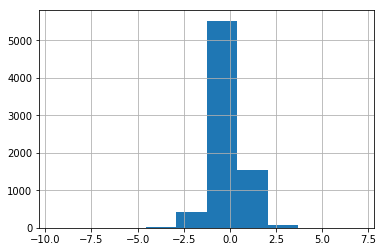

In [68]:
(phenotype_raw['AS1_HIP1']-phenotype_raw['AS1_HIP2']).hist()

In [142]:
phenotype_raw_CT.columns[phenotype_raw_CT.columns.str.contains('BLOOD')]#['CT1_BLOOD16_U']

(phenotype_raw['NC1_CRP'][phenotype_raw['NC1_CRP']!=99999]*0.1).median()

(phenotype_raw['AS1_PDDEM']).value_counts()

#(phenotype_raw['AS1_PREGNO']-phenotype_raw['AS1_CHILD_P']-phenotype_raw['AS1_CHILD_D']).value_counts()

In [11]:
def run_command(series_in,match_value,expression):
    series_out=series_in.copy()
    series_out[series_out.index]=np.nan
    if 'x' in match_value:
        #expression='(x>10)&(x!=77777)&(x!=99999)'
        #Only float variable is supported
        def match_value_function(x):
            try:
                return False if pd.isnull(x) else eval(match_value.replace('x',str(x))) 
            except:
                print(x,end='Error')
                return False
        match_bool=series_in.map(match_value_function)
        expression_function=lambda x:eval(expression.replace('x',str(x)))
        series_out[match_bool]=series_in[match_bool].map(expression_function)
    else:
        #print(np.sum(series_in==float(match_value)))
        try:
            match_value=float(match_value)
        except:
            pass
        try:
            expression=float(expression)
        except:
            pass
        #print(series_in.unique(),(series_in=='폐암').sum(),'폐암',match_value,match_value.strip("'")=='폐암',type('폐암'),type(match_value),match_value,expression)
        if type(match_value)==str and '+' in match_value:
            print("!! contain mode !!")
            series_out[series_in.map(lambda x: False if pd.isnull(x) or type(x)!=str else (match_value.replace('+','') in x))]=expression
        else:
            series_out[series_in==match_value]=expression
    return series_out

#conversion_manual.to_csv(conversion_manual_path,sep='\t',index=None)

'\ndef run_command_multiple(commands):\n    series_converted_final=None\n    for command in commands.split(\' \'):\n        print(command)\n        column_name,match_value,expression=command.split(\'@\')\n        series_converted=run_command(phenotype_raw[column_name],match_value,expression)\n        print(series_converted.unique(),series_converted.sum())\n        if series_converted_final is None:\n            series_converted_final= series_converted\n        else:\n            print("final",series_converted_final.unique())\n            series_converted_final.update(series_converted)\n            print("final",series_converted_final.unique())\n    return series_converted_final\n'

In [ ]:
name_filter='blood_in_urine'
test_match_value=1
test_conversion_value=2

conversion_manual=pd.read_csv(conversion_manual_path,sep='\t',index_col='phenotype_code')


##Run all 'commands' with name=='new_name'
conversion_list_dict={}
for idx,row in conversion_manual.iterrows():
    for command in row['commands'].split('|'):
        new_name,match_value,expression=command.split('@')
        if new_name!=name_filter:
            continue
        print(idx,command,phenotype_raw[idx].unique())
        print("# of filtered={} before: ".format(test_match_value),(phenotype_raw[idx]==test_match_value).sum())
        conversion=run_command(phenotype_raw[idx],match_value,expression)
        conversion_list_dict[new_name]=conversion_list_dict.get(new_name,[])+[conversion]
        print("# of filtered={} after: ".format(test_conversion_value),(conversion==test_conversion_value).sum(),", conversion unique",conversion.unique())
        print('-----------------------------------------')
#print(conversion_list_dict)
print("--------------Conversion----------------------")
# merge results of same 'new_name'
conversion_dict={}
for new_name,conversion_list in conversion_list_dict.items():
    merge_result=None
    for conversion_result in conversion_list:
        if merge_result is None:
            merge_result= conversion_result
        else:
            merge_result.update(conversion_result)
    print(new_name,str(merge_result.unique())[:30])
    conversion_dict[new_name]=merge_result
    

print('# of null:', conversion_dict[name_filter].isnull().sum())

conversion_dict[name_filter].value_counts()
#cohort 별 분포

In [90]:
print('# of {} in AS:'.format(test_conversion_value), phenotype_raw['AS1_contain'][conversion_dict[name_filter]==test_conversion_value].sum(),'/',phenotype_raw['AS1_contain'].sum(),'---','{:.2f}'.format(phenotype_raw['AS1_contain'][conversion_dict[name_filter]==test_conversion_value].sum()/phenotype_raw['AS1_contain'].sum()*100))
print('# of {} in CT:'.format(test_conversion_value), phenotype_raw['CT1_contain'][conversion_dict[name_filter]==test_conversion_value].sum(),'/',phenotype_raw['CT1_contain'].sum(),'---','{:.2f}'.format(phenotype_raw['CT1_contain'][conversion_dict[name_filter]==test_conversion_value].sum()/phenotype_raw['CT1_contain'].sum()*100))
print('# of {} in NC:'.format(test_conversion_value), phenotype_raw['NC1_contain'][conversion_dict[name_filter]==test_conversion_value].sum(),'/',phenotype_raw['NC1_contain'].sum(),'---','{:.2f}'.format(phenotype_raw['NC1_contain'][conversion_dict[name_filter]==test_conversion_value].sum()/phenotype_raw['NC1_contain'].sum()*100))

# of 2 in AS: 0.0 / 7612.0 --- 0.00
# of 2 in CT: 4232.0 / 99234.0 --- 4.26
# of 2 in NC: 98.0 / 19004.0 --- 0.52


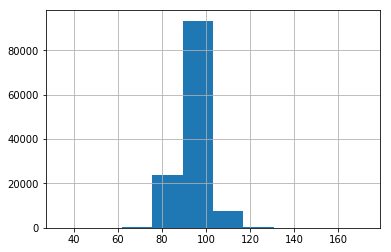

In [78]:
conversion_dict[name_filter].hist()
plt.show()

In [43]:
print('# of {} in AS:'.format(test_match_value), phenotype_raw['AS1_contain'][conversion_dict[name_filter]==test_conversion_value].sum(),'/',phenotype_raw['AS1_contain'].sum(),'---','{:.2f}'.format(phenotype_raw['AS1_contain'][conversion_dict[name_filter]==test_conversion_value].sum()/phenotype_raw['AS1_contain'].sum()*100))
print('# of {} in CT:'.format(test_match_value), phenotype_raw['CT1_contain'][conversion_dict[name_filter]==test_conversion_value].sum(),'/',phenotype_raw['CT1_contain'].sum(),'---','{:.2f}'.format(phenotype_raw['CT1_contain'][conversion_dict[name_filter]==test_conversion_value].sum()/phenotype_raw['CT1_contain'].sum()*100))
print('# of {} in NC:'.format(test_match_value), phenotype_raw['NC1_contain'][conversion_dict[name_filter]==test_conversion_value].sum(),'/',phenotype_raw['NC1_contain'].sum(),'---','{:.2f}'.format(phenotype_raw['NC1_contain'][conversion_dict[name_filter]==test_conversion_value].sum()/phenotype_raw['NC1_contain'].sum()*100))

# of 2 in AS: 0.0 / 7612.0 --- 0.00
# of 2 in CT: 43.0 / 99234.0 --- 0.04
# of 2 in NC: 16.0 / 19004.0 --- 0.08


## Run all

In [ ]:
conversion_manual=pd.read_csv(conversion_manual_path,sep='\t',index_col='phenotype_code')

In [18]:
## Run all 'commands' and group by 'new_name'
conversion_list_dict={}
cnt=0
for idx,row in conversion_manual.iterrows():
    for command in row['commands'].split('|'):
        new_name,match_value,expression=command.split('@')
        conversion=run_command(phenotype_raw[idx],match_value,expression)
        conversion_list_dict[new_name]=conversion_list_dict.get(new_name,[])+[conversion]
        """
        print(series_converted.unique(),series_converted.sum())
        if series_converted_final is None:
            series_converted_final= series_converted
        else:
            print("final",series_converted_final.unique())
            series_converted_final.update(series_converted)
        """
    cnt+=1
    if (cnt%int(conversion_manual.shape[0]/100))==0:
        print("{:.2f}%".format(cnt/conversion_manual.shape[0]*100),end=' ')

NameError: name 'conversion_manual' is not defined

In [ ]:
# merge results of same 'new_name'
conversion_dict={}
for new_name,conversion_list in conversion_list_dict.items():
    merge_result=None
    for conversion_result in conversion_list:
        if merge_result is None:
            merge_result= conversion_result
        else:
            merge_result.update(conversion_result)
    print(new_name,str(merge_result.unique())[:30])
    conversion_dict[new_name]=merge_result

# Run genotype-phenotype association

In [ ]:
for new_name,converson in conversion_dict.items():
    print(conversion_dict[new_name].reset_index().isnull().sum())
    phenotype_tosave=conversion_dict[new_name].reset_index().fillna(-9)
    phenotype_tosave=phenotype_tosave[[phenotype_tosave.columns[0],phenotype_tosave.columns[0],phenotype_tosave.columns[1]]]
    phenotype_tosave.to_csv(pheno_file_path.format(new_name),sep=' ',index=None,header=None)

In [56]:
new_name='ACC'
run_subprocess('plink --bfile {} --assoc --pheno {} --linear --out {}'.format(imputed_bfile_path,pheno_file_path.format(new_name),assoc_file_path.format(new_name)))

------RUN-----
plink --bfile data/genotype/HLA_IMPUTED_Result.KCHIP_HLA.MHC --assoc --pheno data/out_pheno/ACC.pheno --linear --out data/out_assoc/ACC
------ERROR-----
Error: --linear without --all-pheno requires a scalar phenotype.

------OUTPUT-----
PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/
(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to data/out_assoc/ACC.log.
Options in effect:
  --assoc
  --bfile data/genotype/HLA_IMPUTED_Result.KCHIP_HLA.MHC
  --linear
  --out data/out_assoc/ACC
  --pheno data/out_pheno/ACC.pheno

305729 MB RAM detected; reserving 152864 MB for main workspace.
6354 variants loaded from .bim file.
125872 people (45726 males, 80146 females) loaded from .fam.
7531 phenotype values present after --pheno.



(b'PLINK v1.90b6.9 64-bit (4 Mar 2019)            www.cog-genomics.org/plink/1.9/\n(C) 2005-2019 Shaun Purcell, Christopher Chang   GNU General Public License v3\nLogging to data/out_assoc/ACC.log.\nOptions in effect:\n  --assoc\n  --bfile data/genotype/HLA_IMPUTED_Result.KCHIP_HLA.MHC\n  --linear\n  --out data/out_assoc/ACC\n  --pheno data/out_pheno/ACC.pheno\n\n305729 MB RAM detected; reserving 152864 MB for main workspace.\n6354 variants loaded from .bim file.\n125872 people (45726 males, 80146 females) loaded from .fam.\n7531 phenotype values present after --pheno.\n',
 b'Error: --linear without --all-pheno requires a scalar phenotype.\n')

In [ ]:
for new_name,converson in conversion_dict.items():
    run_subprocess('plink --bfile {} --assoc --pheno {} --linear --out {}'.format(imputed_bfile_path,pheno_file_path.format(new_name),assoc_file_path.format(new_name)))

In [ ]:
for new_name,converson in conversion_dict.items():
    run_subprocess('plink --bfile {} --assoc --pheno {} --out {}'.format(imputed_bfile_path,pheno_file_path.format(new_name),assoc_file_path.format(new_name)))

# Histogram